In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import math
import time
from time import strftime, localtime

% matplotlib inline

CUDA = False

# Other Classes

In [2]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super(CausalConv1d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=0,
            dilation=dilation, groups=groups, bias=bias)

        self.left_padding = dilation * (kernel_size - 1)
        
    def forward(self, input):
        temp = torch.unsqueeze(input, 0)
        x = F.pad(temp, (self.left_padding, 0, 0, 0))
        x = torch.squeeze(x, 0)
        
        return super(CausalConv1d, self).forward(x)

In [3]:
class OneHot(nn.Module):
    def __init__(self, quant):
        super(OneHot, self).__init__()
        self.one = torch.sparse.torch.eye(quant)
        
    def forward(self, input):
        return Variable(self.one.index_select(0, input.data)).unsqueeze(0).transpose(1,2)

# Model

In [4]:
class WaveNet(nn.Module):
    def __init__(self, quant = 256, res_size = 512, skip_size = 256, dilation_layers = 10, stacks = 3):
        super(WaveNet, self).__init__()
        self.dilation_layers = dilation_layers
        self.dilations = dilations = [(2**dilation) for dilation in range(dilation_layers)] * stacks
        self.one_hot = OneHot(quant)
        
        self.causal_conv = CausalConv1d(1, res_size, 3)
        
        self.dial_conv = nn.ModuleList([CausalConv1d(res_size, res_size, 3, dilation = d) for d in dilations])
 
        self.dial_skip_conv = nn.ModuleList([CausalConv1d(skip_size, skip_size, 1) for _ in dilations])
        self.dial_res_conv = nn.ModuleList([CausalConv1d(skip_size, res_size, 1) for _ in dilations])
        
        self.end_conv1 = nn.Conv1d(in_channels = skip_size, out_channels = skip_size, kernel_size = 1)
        self.end_conv2 = nn.Conv1d(in_channels = skip_size, out_channels = quant, kernel_size = 1)

    def forward(self, input):
#         output = self.one_hot(input)
        output = input.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)
        output = self.causal_conv(output)
        
        skip_sum = []
        for d_conv, skip_conv, res_conv in zip(self.dial_conv, self.dial_skip_conv, self.dial_res_conv):
            res_output = output
            
            gate_output = self.gated_unit(res_output, d_conv)
            
            output = res_conv(gate_output)
            output = output + res_output[:,:,-output.size(2):]
            
            skip = skip_conv(gate_output)
            skip_sum.append(skip)
        
        output = sum([s[:,:,-output.size(2):] for s in skip_sum])
        
        output = self.postprocess(output)
        
        return output
    
    def gated_unit(self, input, dial_conv):
        output = dial_conv(input)
        
        output_sigmoid = output[0][256:].unsqueeze(0)
        output_tanh = output[0][:256].unsqueeze(0)

        output = F.sigmoid(output_sigmoid) * F.tanh(output_tanh)
        
        return output
        
    def postprocess(self, input):
        output = F.relu(input)
        output = self.end_conv1(output)
        output = F.relu(output)
        output = self.end_conv2(output).squeeze(0).transpose(0,1)

        return output

# mu Encoder and Decoder

In [5]:
def mu_encoder(input):        
    mu = torch.FloatTensor([255])
    x_mu = torch.sign(input) * torch.log1p(mu * torch.abs(input)) / torch.log1p(mu)
    x_mu = ((x_mu + 1) / 2 * mu + 0.5).long()
    
    return x_mu.type(torch.FloatTensor) 

In [6]:
def mu_decoder(input):
    mu = torch.FloatTensor([255])
    x = ((input) / mu) * 2 - 1.
    x = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1.) / mu
    
    return x

# Data Generator

In [7]:
def batch_generator():
    while True:
        xs = np.linspace(0, np.pi*10, 4000)
        ys = np.sin(xs)
        ys = ys.astype(np.float32)
        x = torch.from_numpy(ys).view(1, 1, -1)
        
        if (torch.cuda.is_available() and CUDA):
            x = x.cuda()
            
        yield x

g = batch_generator()

In [ ]:
x = next(g)
plt.figure(figsize=[8,6])
plt.plot(Variable(x).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_encoder(x)
# plt.figure(figsize=[8,6])
# plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_decoder(temp)
plt.figure(figsize=[8,6])
plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

# Load / Save functions

In [8]:
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print("Checkpoint saved: " + filename)

In [9]:
def load_checkpoint(filename):
    net = WaveNet()

    checkpoint = torch.load(filename)
    net.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']
    loss_save = checkpoint['loss_save']
    optimizer = optim.Adam(net.parameters(),lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    print("Loaded checkpoint: " + filename)
    return net, epoch, loss_save, optimizer

# Training

Loaded checkpoint: checkpoint_epoch_140_2018_01_20__00_38.pth
Batch 0 done in 6.87 seconds
Batch 1 done in 4.32 seconds
It took 40.02 seconds to finish an epoch
Batch 0 done in 3.96 seconds
Batch 1 done in 4.14 seconds
It took 36.56 seconds to finish an epoch
Batch 0 done in 3.88 seconds
Batch 1 done in 3.88 seconds
It took 36.40 seconds to finish an epoch
Batch 0 done in 3.87 seconds
Batch 1 done in 3.87 seconds
It took 36.01 seconds to finish an epoch
Batch 0 done in 3.88 seconds
Batch 1 done in 3.89 seconds
It took 36.07 seconds to finish an epoch
epoch 145, loss 1.24932777882


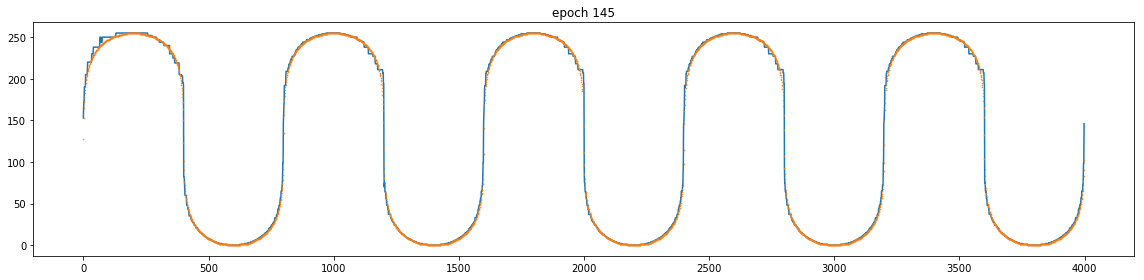

Batch 0 done in 3.88 seconds
Batch 1 done in 3.88 seconds
It took 35.94 seconds to finish an epoch
Batch 0 done in 3.89 seconds
Batch 1 done in 3.88 seconds
It took 36.18 seconds to finish an epoch
Batch 0 done in 3.88 seconds
Batch 1 done in 3.88 seconds
It took 36.26 seconds to finish an epoch
Batch 0 done in 3.89 seconds
Batch 1 done in 3.91 seconds
It took 36.34 seconds to finish an epoch
Batch 0 done in 3.90 seconds
Batch 1 done in 3.91 seconds
It took 36.38 seconds to finish an epoch
epoch 150, loss 1.21667850018


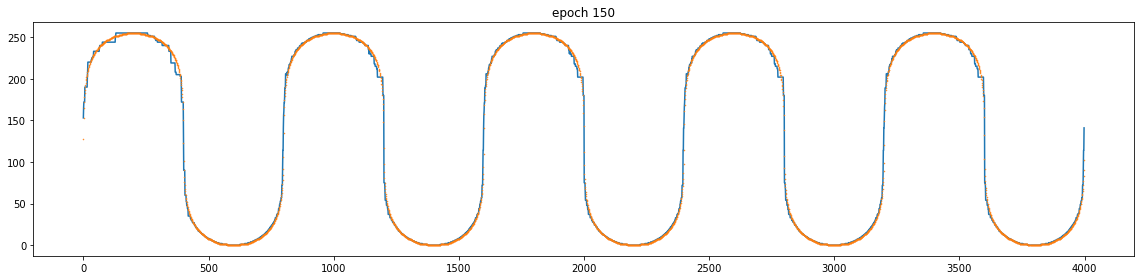

Checkpoint saved: checkpoint_epoch_150_2018_01_20__01_01.pth
It took 0.25 seconds to save data file
Batch 0 done in 3.90 seconds
Batch 1 done in 3.91 seconds
It took 36.34 seconds to finish an epoch
Batch 0 done in 3.89 seconds
Batch 1 done in 3.88 seconds
It took 36.31 seconds to finish an epoch
Batch 0 done in 3.86 seconds
Batch 1 done in 3.88 seconds
It took 36.18 seconds to finish an epoch
Batch 0 done in 3.87 seconds
Batch 1 done in 3.86 seconds
It took 36.09 seconds to finish an epoch
Batch 0 done in 3.86 seconds
Batch 1 done in 3.87 seconds
It took 36.05 seconds to finish an epoch
epoch 155, loss 1.18631601334


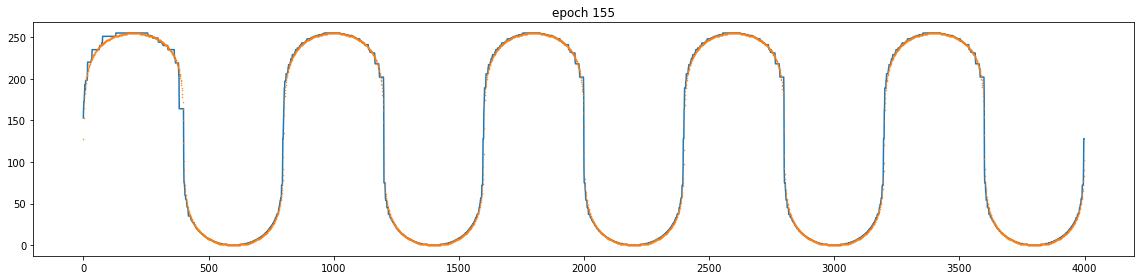

Batch 0 done in 3.87 seconds
Batch 1 done in 3.86 seconds
It took 36.07 seconds to finish an epoch
Batch 0 done in 3.86 seconds
Batch 1 done in 3.86 seconds
It took 36.04 seconds to finish an epoch
Batch 0 done in 3.87 seconds
Batch 1 done in 3.87 seconds
It took 36.05 seconds to finish an epoch
Batch 0 done in 3.86 seconds
Batch 1 done in 3.85 seconds
It took 35.95 seconds to finish an epoch
Batch 0 done in 3.86 seconds
Batch 1 done in 3.85 seconds
It took 35.92 seconds to finish an epoch
epoch 160, loss 1.20340561867


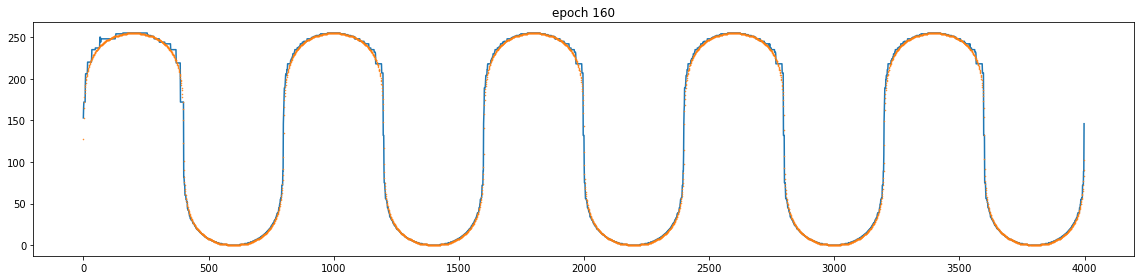

Checkpoint saved: checkpoint_epoch_160_2018_01_20__01_07.pth
It took 0.28 seconds to save data file
It took 744.39 seconds to finish training


In [10]:
try:
    net, epoch, loss_save, optimizer = load_checkpoint("checkpoint_epoch_140_2018_01_20__00_38.pth")
except:
    print("No checkpoint found - Initializing new training")
    net = WaveNet()
    loss_save = []
    epoch = 0
    optimizer = optim.Adam(net.parameters(), lr = 0.001)

batch_size = 2
max_epoch = 20
start = time.time()

for _ in range(max_epoch):
    start_epoch = time.time()
    epoch += 1
    optimizer.zero_grad()
    loss = 0
    
    for ind in range(batch_size):
        start_batch = time.time()
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        sz = logits.size(0)
        loss = loss + nn.functional.cross_entropy(logits, batch[0][0][-sz:])
        print("Batch " + str(ind) + " done in {0:0.2f} seconds".format(time.time() - start_batch))
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    
    print('It took {0:0.2f} seconds to finish an epoch'.format(time.time() - start_epoch))
    
    # monitor progress
    if epoch%5 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(x.data.tolist(),'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()
        
    if epoch%10 == 0:
        start_save = time.time()
        cp = "checkpoint_epoch_" + str(epoch) + "_" + strftime("%Y_%m_%d__%H_%M", localtime()) + '.pth'
        save_checkpoint({
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'loss_save' : loss_save,
        }, cp)
        print('It took {0:0.2f} seconds to save data file'.format(time.time() - start_save))
        
print('It took {0:0.2f} seconds to finish training'.format(time.time() - start))

# Loss Graph

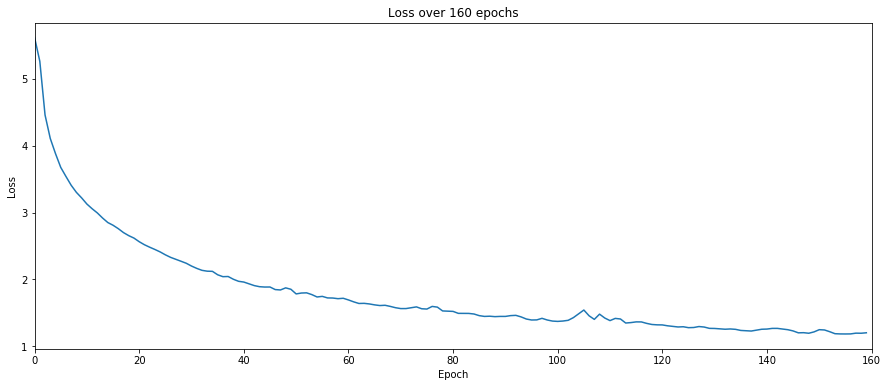

In [15]:
plt.figure(figsize=[15,6])
plt.plot(loss_save)
plt.xlim([0, len(loss_save)])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss over {} epochs'.format(len(loss_save)))
plt.show()

# Predicting from sine data

In [ ]:
batch = next(g)
x = mu_encoder(batch).type(torch.LongTensor)
n = 500
predict_save = []

for _ in range(n):
    temp = Variable(x)
    inputs = temp[0][0][:-1]
    predict = net(inputs)
    _, i = predict.max(dim=1)
    predict_save.append(i.data[-1])
    x = np.roll(x, -1, axis=2)
    x[0][0][-1] = i.data[-1]
    x = torch.from_numpy(x)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.xlim([0, n])
plt.title('Prediction from sine wave input')
plt.show()

# Predict from random data

In [ ]:
x = torch.from_numpy(np.random.randint(256, size=(1,1,4000)))
n = 500
predict_save = []

for _ in range(n):
    temp = Variable(x)
    inputs = temp[0][0][:-1]
    predict = net(inputs)
    _, i = predict.max(dim=1)
    predict_save.append(i.data[-1])
    x = np.roll(x, -1, axis=2)
    x[0][0][-1] = i.data[-1]
    x = torch.from_numpy(x)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.xlim([0, n])
plt.title('Prediction from random wave input')
plt.show()